In [86]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# birdnet mixit analysis

Let's do some quick and dirty analysis of a few of the bird calls.
The goal in the notebook is to figure out if we can extract call/no-call information and plot it in a reasonable way.

In [87]:
from birdclef.utils import get_spark
from pyspark.sql import functions as F

spark = get_spark()

In [88]:
birdclef_root = "../data/raw/birdclef-2023"
train_metadata_df = spark.read.csv(f"{birdclef_root}/train_metadata.csv", header=True)
train_metadata_df.printSchema()

root
 |-- primary_label: string (nullable = true)
 |-- secondary_labels: string (nullable = true)
 |-- type: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- scientific_name: string (nullable = true)
 |-- common_name: string (nullable = true)
 |-- author: string (nullable = true)
 |-- license: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- url: string (nullable = true)
 |-- filename: string (nullable = true)



In [89]:
durations_df = spark.read.parquet(
    "gs://birdclef-2023/data/processed/birdclef-2023/train_durations_v2.parquet"
)
durations_df.show(n=5)

+--------------------+------------------+
|            filename|          duration|
+--------------------+------------------+
|abethr1/XC128013.ogg| 45.60979591836735|
|abethr1/XC363501.ogg|18.677596371882085|
|abethr1/XC363502.ogg| 38.76575963718821|
|abethr1/XC363503.ogg|29.257188208616782|
|abethr1/XC363504.ogg| 42.34453514739229|
+--------------------+------------------+
only showing top 5 rows



Lets get all tracks that are 30 +/- 1 seconds long.

In [90]:
subset_durations = durations_df.where("duration > 29 and duration < 31")
subset_durations.show(n=5)
subset_durations.count()

+--------------------+------------------+
|            filename|          duration|
+--------------------+------------------+
|abethr1/XC363503.ogg|29.257188208616782|
|abhori1/XC398894.ogg|29.283038548752835|
|abhori1/XC410289.ogg|             30.72|
|abhori1/XC428883.ogg|29.492290249433108|
|abhori1/XC585198.ogg|30.048027210884353|
+--------------------+------------------+
only showing top 5 rows



470

Now lets grab a single track and do some analysis.

- Plot a spectrogram
- Get the top 5 species ranked by prediction, and determine a threshold for birdcall
- Plot the time series next to the spectogram
- Sound separate using 4 tracks; repeat spectrogram and time series
- Sound separate using 8 tracks; repeat spectrogram and time series

## spectrogram and ranked prediction time series

In [91]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

first_track = subset_durations.first().filename
y, sr = librosa.load(f"{birdclef_root}/train_audio/{first_track}", sr=48_000)
print(y.shape)

(1404344,)


In [92]:
# let's listen to it
import IPython.display as ipd

ipd.Audio(f"{birdclef_root}/train_audio/{first_track}")

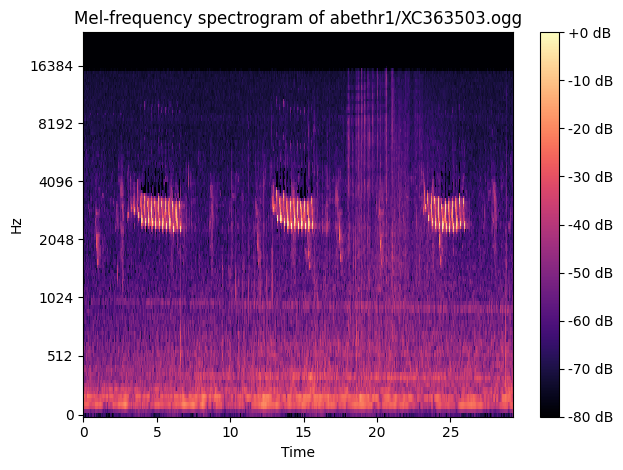

In [93]:
# generate a spectrogram and plot it
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel-frequency spectrogram of {first_track}")
plt.tight_layout()
plt.show()

In [94]:
# let's run this through the birdnet model
from birdclef.data.utils import slice_seconds
from birdclef import birdnet

# TODO: fix this model so it doesn't spew out a bunch of warnings...
model_path = "../vendor/BirdNET-Analyzer/checkpoints/V2.2/BirdNET_GLOBAL_3K_V2.2_Model/"
model = birdnet.load_model(model_path, model_attr="model")
prediction_func = birdnet.prediction_func(model)

In [95]:
X = slice_seconds(y, sr, seconds=3, step=1)
print("shape of sliced input", X.shape)

# transform the data
pred = prediction_func(X)[0]
print("shape of prediction", pred.shape)

shape of sliced input (28, 144000)
shape of prediction (28, 3337)


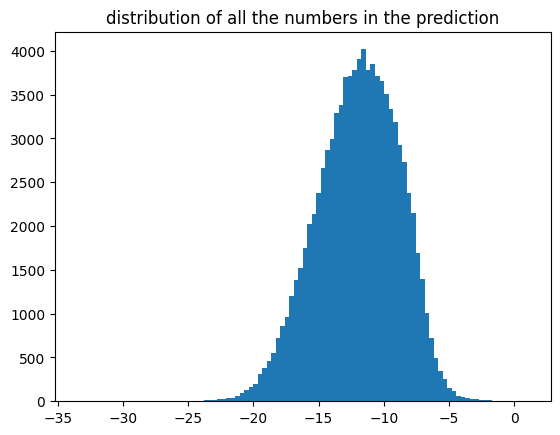

In [96]:
# what is the distribution of all the numbers?
plt.hist(pred.flatten(), bins=100)
plt.title("distribution of all the numbers in the prediction")
plt.show()

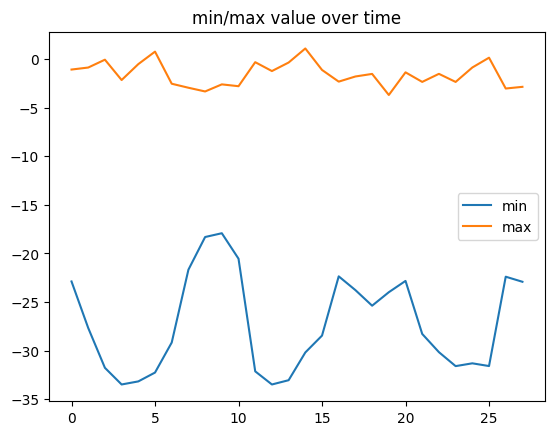

In [97]:
# what the min and max values over time?
plt.plot(pred.min(axis=1), label="min")
plt.plot(pred.max(axis=1), label="max")
plt.title("min/max value over time")
plt.legend()
plt.show()

Looking at this plot, these values are probably a negative log probability.
What threshold should we use to determine if there is a bird call?
We just have to apply a sigmoid function and then pick a threshold.

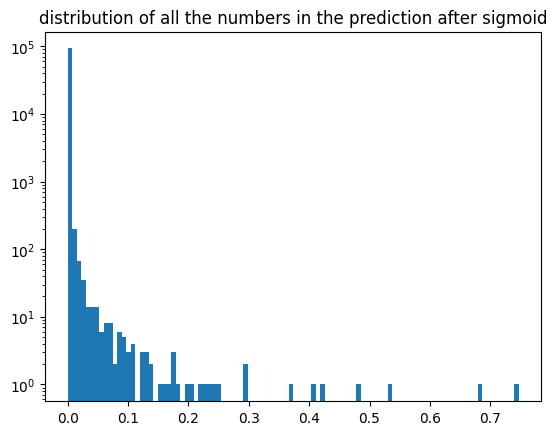

In [98]:
# apply sigmoid function to all the data
pred_sigmoid = 1 / (1 + np.exp(-pred))
# log scale the bin counts
plt.hist(pred_sigmoid.flatten(), bins=100, log=True)
plt.title("distribution of all the numbers in the prediction after sigmoid")
plt.show()

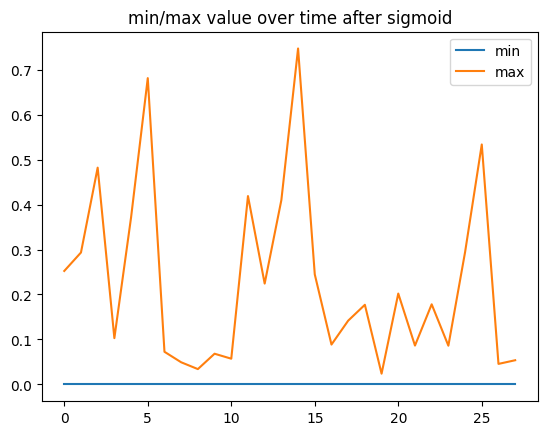

In [99]:
# what the min and max values over time?
plt.plot(pred_sigmoid.min(axis=1), label="min")
plt.plot(pred_sigmoid.max(axis=1), label="max")
plt.title("min/max value over time after sigmoid")
plt.legend()
plt.show()

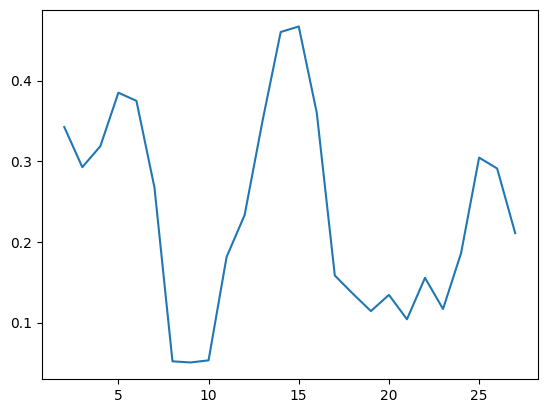

In [100]:
# lets smooth the max value by 1 element
import pandas as pd

max_smoothed = pd.Series(pred_sigmoid.max(axis=1)).rolling(3).mean().values
plt.plot(max_smoothed, label="max")
plt.show()

What are the top5 predictions by confidence? We do this by filtering the top values per time step, and then then taking the top 5 over the entire time series.

In [101]:
# What are the top 5 predictions by confidence?
top10 = np.argsort(pred_sigmoid, axis=1)[:, -10:]
print(top10.shape)
print(top10[:3])

# get the 5 most frequent values from the top 10
# https://stackoverflow.com/a/28736715
values, counts = np.unique(top10, return_counts=True)
ind = np.argpartition(-counts, kth=5)[:5]
top5 = values[ind]
print(top5)

(28, 10)
[[  49 2596 1318 2936 1435 1008 2076  537  746 2081]
 [3009 2075 1505  679 1499 3131   49  839  938 3007]
 [1505  839 3269 3009  484  266 1823  679 1758  324]]
[ 324  679 1823 1819 1758]


In [102]:
def rank_indices(pred, k=10):
    topk = np.argsort(pred, axis=1)[:, -k * 2 :]
    values, counts = np.unique(topk, return_counts=True)
    ind = np.argpartition(-counts, kth=k)[:k]
    return values[ind]

In [103]:
from pathlib import Path
import json

labels_path = (
    "../vendor/BirdNET-Analyzer/checkpoints/V2.2/BirdNET_GLOBAL_3K_V2.2_Labels.txt"
)
mapping_path = "../vendor/BirdNET-Analyzer/eBird_taxonomy_codes_2021E.json"

labels = Path(labels_path).read_text().splitlines()
mapping = json.loads(Path(mapping_path).read_text())
mapped_labels = [mapping[label] for label in labels]

Lets plot the top 5 predictions over time.

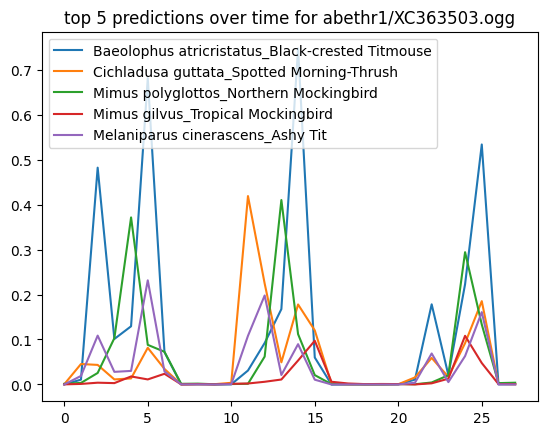

In [104]:
top5 = rank_indices(pred_sigmoid, k=5)
for idx in top5:
    plt.plot(pred_sigmoid[:, idx], label=labels[idx])
plt.title(f"top 5 predictions over time for {first_track}")
plt.legend()
plt.show()

Let's plot the log likelihoods instead and see how it compares.

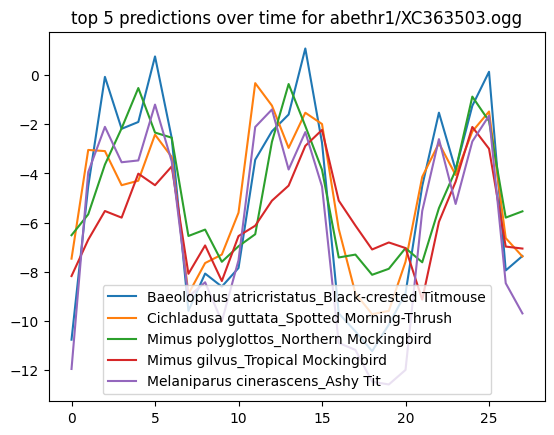

In [105]:
top5 = rank_indices(pred, k=5)
for idx in top5:
    plt.plot(pred[:, idx], label=labels[idx])
plt.title(f"top 5 predictions over time for {first_track}")
plt.legend()
plt.show()

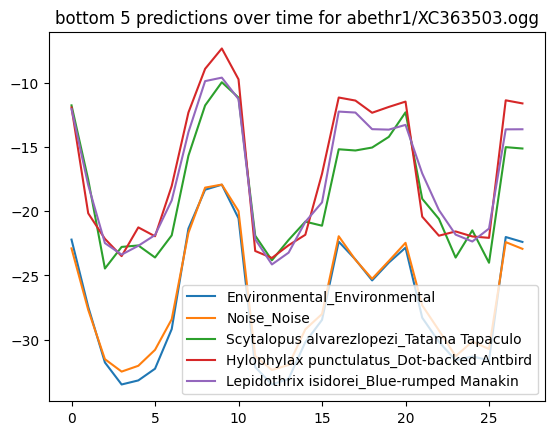

In [106]:
top5 = rank_indices(-pred, k=5)
for idx in top5:
    plt.plot(pred[:, idx], label=labels[idx])
plt.title(f"bottom 5 predictions over time for {first_track}")
plt.legend()
plt.show()

## sound separation and ranked prediction

In [107]:
first_track

'abethr1/XC363503.ogg'

In [108]:
cmd = f"""
docker run --rm \
    -u $(id -u):$(id -g) \
    -v $PWD/../data:/mnt/data \
    -it us-central1-docker.pkg.dev/birdclef-2023/birdclef-2023/bird-mixit:latest \
        python scripts/mixit_wrapper.py \
            --input /mnt/data/raw/birdclef-2023/train_audio/{first_track} \
            --output /mnt/data/processed/birdclef-2023/mixit/{first_track} \
            --model_name output_sources4 \
            --num_sources 4
"""
! {cmd}

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [109]:
mixit_root = "../data/processed/birdclef-2023/mixit"
! ls {mixit_root}/abethr1

XC363503_source0.ogg  XC363503_source2.ogg
XC363503_source1.ogg  XC363503_source3.ogg


In [110]:
# load the sources and show the spectrograms
track_path = Path(first_track)
paths = sorted(Path(mixit_root).glob(f"*/{stem}_source*"))
paths

[PosixPath('../data/processed/birdclef-2023/mixit/abethr1/XC363503_source0.ogg'),
 PosixPath('../data/processed/birdclef-2023/mixit/abethr1/XC363503_source1.ogg'),
 PosixPath('../data/processed/birdclef-2023/mixit/abethr1/XC363503_source2.ogg'),
 PosixPath('../data/processed/birdclef-2023/mixit/abethr1/XC363503_source3.ogg')]

In [111]:
sr = 48_000
series = [librosa.load(path, sr=sr)[0] for path in paths]

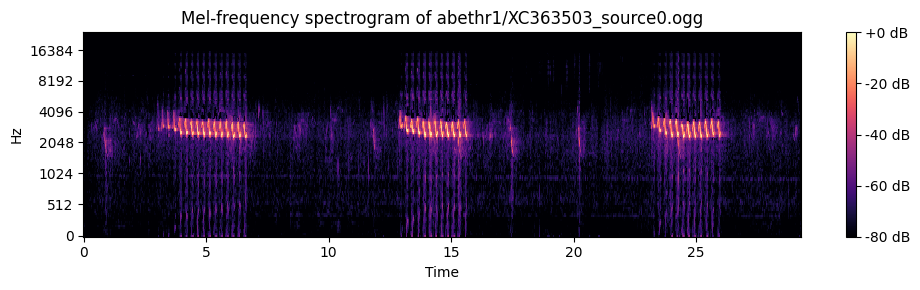

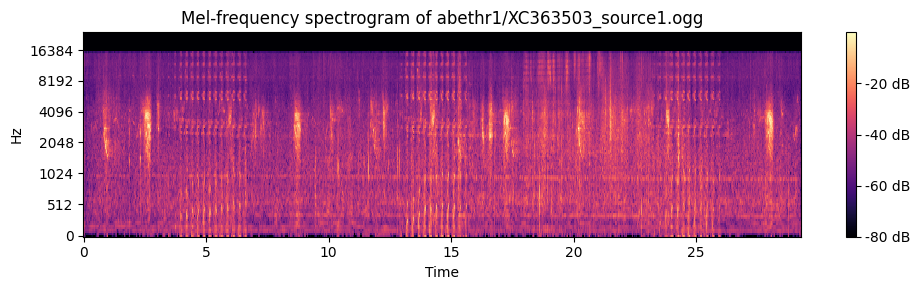

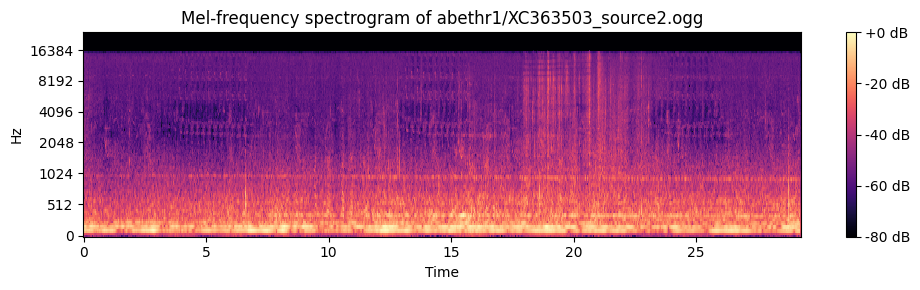

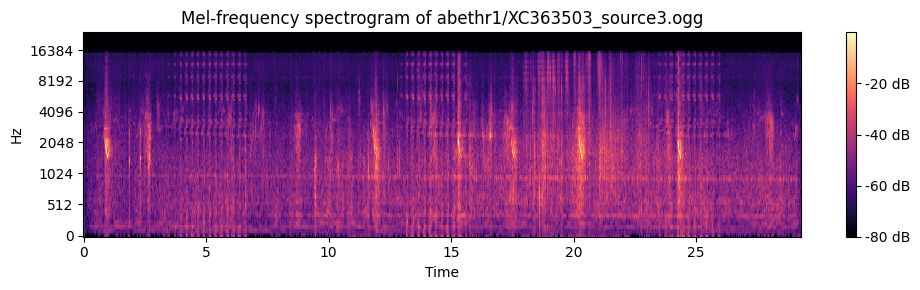

In [112]:
# plot the spectrograms
for y, path in zip(series, paths):
    plt.figure(figsize=(10, 3))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel-frequency spectrogram of {path.parts[-2]}/{path.parts[-1]}")
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(path))

Lets create top5 and bottom5 predictions for each track

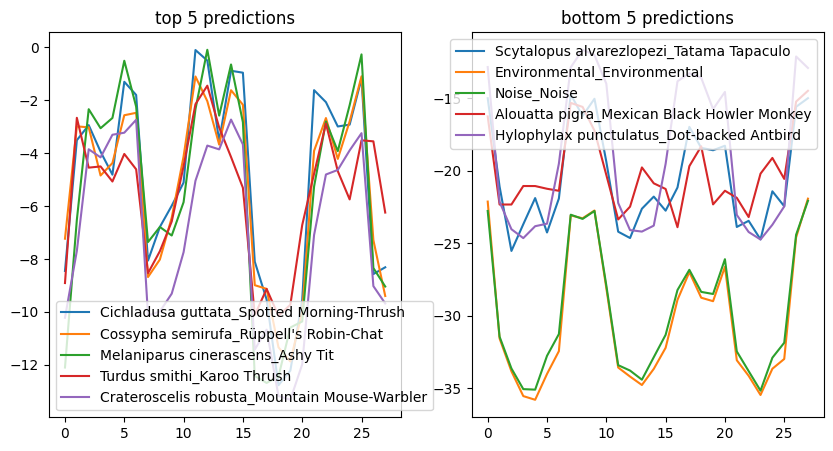

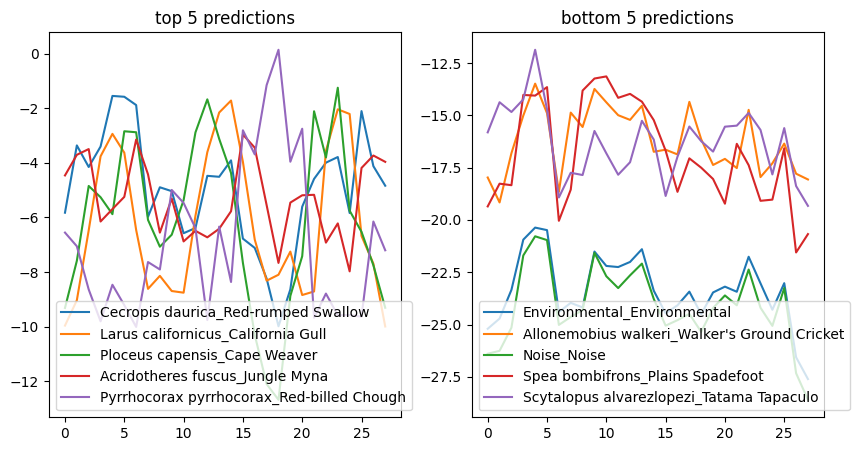

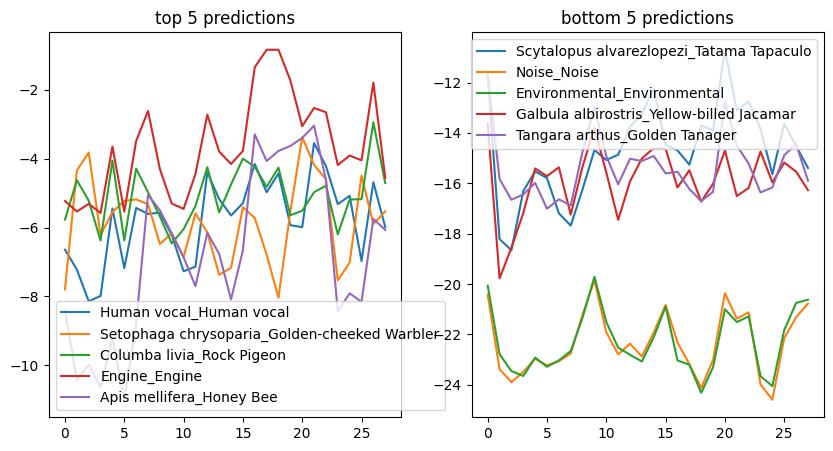

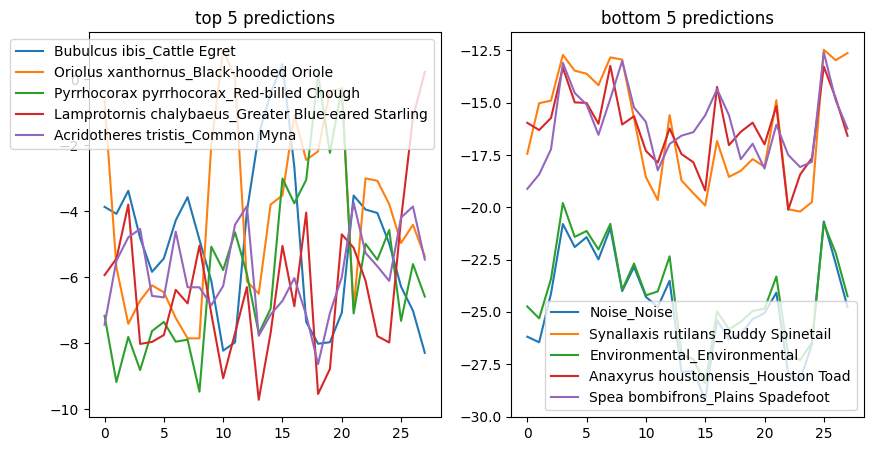

In [113]:
for y, path in zip(series, paths):
    X = slice_seconds(y, sr, seconds=3, step=1)
    pred = prediction_func(X)[0]
    # create a subplot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for idx in rank_indices(pred, k=5):
        ax[0].plot(pred[:, idx], label=labels[idx])
        ax[0].set_title("top 5 predictions")
        ax[0].legend()
    for idx in rank_indices(-pred, k=5):
        ax[1].plot(pred[:, idx], label=labels[idx])
        ax[1].set_title("bottom 5 predictions")
        ax[1].legend()
    plt.show()